In [1]:
#Main Code and Value Iteration

import numpy as np
import nashpy as nash
from copy import deepcopy
import math
import random
import time

np.random.seed(100)
random.seed(100)
 
states = 50
actions = 5
discount = 0.6
max_iterations = 1000 #100000

total_avgs = 50

P = np.zeros((actions,actions,states,states))
R = np.random.random((actions,actions,states))

for a1 in range(actions):
    for a2 in range(actions):
        for s in range(states):
            P[a1,a2,s] = np.random.random(states)
            P[a1][a2][s][s] = states #check this. 
            P[a1,a2,s] = P[a1,a2,s] / P[a1,a2,s].sum()
            
#Value Iteration Starts

V = np.zeros(states) #Initial value
while True:
    Q = np.zeros((actions,actions,states))
    for a1 in range(actions):
        for a2 in range(actions):
            Q[a1,a2] = R[a1,a2] + discount * P[a1,a2].dot(V)

    v_prev = deepcopy(V)
    #print(v_prev)
    for s in range(states):
        #print(Q[:,:,s])
        rps = nash.Game(Q[:,:,s])
        #print(rps)
        eqs = rps.lemke_howson(1)
        #print(list(eqs))
        V[s] = rps[list(eqs)][0]
        #print(rps[list(eqs)])

    #print(v_prev)
    #print(V)
    #print(v_prev)
    #print(np.linalg.norm(V-v_prev))

    if np.linalg.norm(V-v_prev) < 0.000001:
        break



In [2]:
#Standard minimax Q-Learning

starttime = time.time()

store_avgs = np.zeros((total_avgs,1))

P_update_time = max_iterations/10
for avg in range(total_avgs):
    Q = np.random.rand(states,actions,actions)
    state = np.random.randint(0, states)
    
    tot_count = np.zeros((actions,actions,states,states))

    w = 1

    for n in range(max_iterations):

        if (n % 100) == 0:
            state = np.random.randint(0, states)

        act1 = random.randint(0,actions-1)
        act2 = random.randint(0,actions-1)


        p_s_new = np.random.random()
        p = 0
        s_new = -1
        while (p < p_s_new) and (s_new < (states - 1)):
            s_new = s_new + 1
            #print(a1,a2,s,s_new)
            p = p + P[act1][act2][state][s_new]

        r = R[act1][act2][state]

        #print(Q[s_new,:,:])

        tot_count[act1][act2][state][s_new] += 1 


        rps = nash.Game(Q[state,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        current_state_value = rps[list(eqs)][0]


        rps = nash.Game(Q[s_new,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        next_state_value = rps[list(eqs)][0]

        delta = r + discount * next_state_value - Q[state, act1,act2]
        delta = w *(r + discount* next_state_value) + (1-w)*current_state_value - Q[state, act1,act2]
        dQ = (1 / math.sqrt(np.sum(tot_count[act1][act2][state]))) * delta  
#         dQ = 0.9 * delta 
        Q[state, act1,act2] += dQ
        state = s_new

    sor_minimax_Q = np.zeros(states)
    for i in range(states):
        rps = nash.Game(Q[i,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
#         print(list(eqs))
        sor_minimax_Q[i] =  rps[list(eqs)][0]
    
    store_avgs[avg][0] = np.linalg.norm(V - sor_minimax_Q)
#     print(np.linalg.norm(V - sor_minimax_Q))    

print(np.average(store_avgs),np.std(store_avgs))    
print('That took {} seconds'.format(time.time() - starttime))


3.9927864342449384 0.11201396058244908
That took 152.84258127212524 seconds


In [3]:
#Generalised Optimal minimax Q-Learning

starttime = time.time()

store_avgs = np.zeros((total_avgs,1))

P_update_time = max_iterations/10
store_w = np.zeros((max_iterations,total_avgs))

w = 100
        
for a1 in range(actions):
    for a2 in range(actions):
        for s in range(states):
            temp = 1/(1 - (discount*P[a1][a2][s][s]))
            if w > temp:
                w = temp

print("optimal w* is",w)


for avg in range(total_avgs):
    Q = np.random.rand(states,actions,actions)
    state = np.random.randint(0, states)
    

    tot_count = np.zeros((actions,actions,states,states))
    
    for n in range(max_iterations):

        if (n % 100) == 0:
            state = np.random.randint(0, states)

        act1 = random.randint(0,actions-1)
        act2 = random.randint(0,actions-1)


        p_s_new = np.random.random()
        p = 0
        s_new = -1
        while (p < p_s_new) and (s_new < (states - 1)):
            s_new = s_new + 1
            #print(a1,a2,s,s_new)
            p = p + P[act1][act2][state][s_new]

        r = R[act1][act2][state]

        #print(Q[s_new,:,:])

        tot_count[act1][act2][state][s_new] += 1 

        store_w[n][avg] = w

        rps = nash.Game(Q[state,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        current_state_value = rps[list(eqs)][0]


        rps = nash.Game(Q[s_new,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        next_state_value = rps[list(eqs)][0]

        delta = r + discount * next_state_value - Q[state, act1,act2]
        delta = w *(r + discount* next_state_value) + (1-w)*current_state_value - Q[state, act1,act2]
        dQ = (1 / math.sqrt(np.sum(tot_count[act1][act2][state]))) * delta  #Doesn't satisfy conditions in theory
#         dQ = 0.9 * delta 
        Q[state, act1,act2] += dQ
        state = s_new

    sor_minimax_Q = np.zeros(states)
    for i in range(states):
        rps = nash.Game(Q[i,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
#         print(list(eqs))
        sor_minimax_Q[i] =  rps[list(eqs)][0]
    
    store_avgs[avg][0] = np.linalg.norm(V - sor_minimax_Q)
#     print(np.linalg.norm(V - sor_minimax_Q))    

print(np.average(store_avgs),np.std(store_avgs))     
print('That took {} seconds'.format(time.time() - starttime))


optimal w* is 1.593941837381986
3.5909074873884026 0.13935935773612676
That took 158.2646083831787 seconds


In [4]:
#Generalised Minimax Q-Learning

starttime = time.time()

store_avgs = np.zeros((total_avgs,1))

P_update_time = max_iterations/10
store_w = np.zeros((max_iterations,total_avgs))
for avg in range(total_avgs):
    Q = np.random.rand(states,actions,actions)
    state = np.random.randint(0, states)
    

    tot_count = np.zeros((actions,actions,states,states))

    w = 1
    
    for n in range(max_iterations):

        if (n % 100) == 0:
            state = np.random.randint(0, states)

        act1 = random.randint(0,actions-1)
        act2 = random.randint(0,actions-1)


        p_s_new = np.random.random()
        p = 0
        s_new = -1
        while (p < p_s_new) and (s_new < (states - 1)):
            s_new = s_new + 1
            #print(a1,a2,s,s_new)
            p = p + P[act1][act2][state][s_new]

        r = R[act1][act2][state]

        #print(Q[s_new,:,:])

        tot_count[act1][act2][state][s_new] += 1 

        if n > P_update_time:  #Doing it after initial 1000 iterations
            new_w = 100
            for a1 in range(actions):
                for a2 in range(actions):
                    for s in range(states):
                        if np.sum(tot_count[a1][a2][s][s]) > 0:
                            temp = 1/(1 - (discount*(tot_count[a1][a2][s][s]/np.sum(tot_count[a1][a2][s]))))
                            #print(temp)
                            if new_w > temp:
                                new_w = temp

            w = (1-0.5)*w+(0.5)*new_w
    #     #     print(w)


        store_w[n][avg] = w

        rps = nash.Game(Q[state,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        current_state_value = rps[list(eqs)][0]


        rps = nash.Game(Q[s_new,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
        next_state_value = rps[list(eqs)][0]

        delta = r + discount * next_state_value - Q[state, act1,act2]
        delta = w *(r + discount* next_state_value) + (1-w)*current_state_value - Q[state, act1,act2]
        dQ = (1 / math.sqrt(np.sum(tot_count[act1][act2][state]))) * delta  #Doesn't satisfy conditions in theory
#         dQ = 0.9 * delta 
        Q[state, act1,act2] += dQ
        state = s_new

    sor_minimax_Q = np.zeros(states)
    for i in range(states):
        rps = nash.Game(Q[i,:,:])
        #print(rps)
        eqs = rps.lemke_howson(0)
#         print(list(eqs))
        sor_minimax_Q[i] =  rps[list(eqs)][0]
    
    store_avgs[avg][0] = np.linalg.norm(V - sor_minimax_Q)
#     print(np.linalg.norm(V - sor_minimax_Q))    

print(np.average(store_avgs),np.std(store_avgs))     
print('That took {} seconds'.format(time.time() - starttime))


3.803794811333769 0.11916859236845724
That took 759.1033823490143 seconds


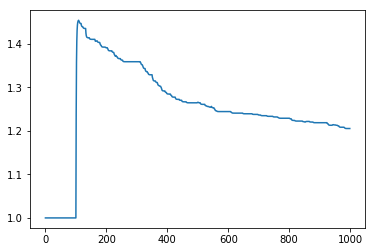

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.average(store_w,axis = 1))